In [1]:
# Goal1 - class distribution visualization
# Goal2 - how many bbox we need?
# Goal3 - bbox's range visualization
# Goal4 - bbox's correlation
# Goal5 - statistics table

# 좋은 Validation set이란?
# • Validation set의 스코어가 올랐을 때, Public score가 올라감
# • Validation set의 스코어가 올랐을 때, Private score가 올라감
# • Public과 Private score가 모두 올라야 좋은 validation set
# Validation 전략 – Stratified K fold
# Data Augmentation – Mosaic3

In [2]:
# Import Library
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports
from datetime import datetime
from glob import glob
import warnings
import IPython
import urllib
import zipfile
import pickle
import shutil
import string
import math
import tqdm
import time
import os
import gc
import re

# Visualization Imports
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches4
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "browser"
import PIL
import cv2
from pycocotools.coco import COCO

# Other Imports
from tqdm.notebook import tqdm


LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

In [32]:
def load(cfg):
    coco = COCO(cfg.anno_path)
    
    train_df = pd.DataFrame()
    image_ids = []
    class_name = []
    class_id = []
    x_min = []
    y_min = []
    x_max = []
    y_max = []
    for image_id in coco.getImgIds():
        image_info = coco.loadImgs(image_id)[0]
        ann_ids = coco.getAnnIds(imgIds=image_info['id'])
        anns = coco.loadAnns(ann_ids)
        
        file_name = image_info['file_name']
        
        for ann in anns:
            image_ids.append(file_name)
            class_name.append(cfg.classes[ann['category_id']])
            class_id.append(ann['category_id'])
            x_min.append(float(ann['bbox'][0]))
            y_min.append(float(ann['bbox'][1]))
            x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
            y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

    train_df['image_id'] = image_ids
    train_df['class_name'] = class_name
    train_df['class_id'] = class_id
    train_df['x_min'] = x_min
    train_df['y_min'] = y_min
    train_df['x_max'] = x_max
    train_df['y_max'] = y_max
    
    return train_df 

def sample(df, cnt): display(df.sample(cnt))

def hist_ann_per_img(df, cfg):
    ## Annotation Per Images
    fig = px.histogram(df.image_id.value_counts(), 
                    log_y=True, color_discrete_sequence=['indianred'], opacity=0.7,
                    labels={"value":"Number of Annotations Per Image"},
                    title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER IMAGE<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                    height=cfg.hist_height, width=cfg.hist_width
                    )
    fig.update_layout(showlegend=False,
                    xaxis_title="<b>Number of Unique Images</b>",
                    yaxis_title="<b>Count of All Object Annotations</b>",)
    fig.write_image('output/ann_per_img.png')
    
def hist_cls_per_img(df, cfg):
    ## Unique Class Per Image
    fig = px.histogram(df.groupby('image_id')["class_id"].unique().apply(lambda x: len(x)), 
                    log_y=True, color_discrete_sequence=['skyblue'], opacity=0.7,
                    labels={"value":"Number of Unique class"},
                    title="<b>DISTRIBUTION OF # OF Unique Class PER IMAGE<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                    height=cfg.hist_height, width=cfg.hist_width
                    )
    fig.update_layout(showlegend=False,
                    xaxis_title="<b>Number of Unique CLASS</b>",
                    yaxis_title="<b>Count of Unique IMAGE</b>",)
    fig.write_image('output/cls_per_img.png')
        
def hist_ann_per_cls(df, cfg):
    ## Annotations Per Class
    fig = px.bar(df.class_name.value_counts().sort_index(), 
                    color=df.class_name.value_counts().sort_index().index, opacity=0.85,
                    color_discrete_sequence=LABEL_COLORS, log_y=True,
                    labels={"y":"Annotations Per Class", "x":""},
                    title="<b>Annotations Per Class<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                    height=cfg.hist_height, width=cfg.hist_width
                )
    fig.update_layout(legend_title=None,
                    xaxis_title="",
                    yaxis_title="<b>Annotations Per Class</b>")
    fig.write_image('output/cls_per_img.png')
    
def convert_to_bbox(df):
    bbox_df = pd.DataFrame()
    bbox_df['class_id'] = df['class_id'].values
    bbox_df['class_name'] = df['class_name'].values
    bbox_df['x_min'] = df['x_min'].values / 1024
    bbox_df['x_max'] = df['x_max'].values / 1024
    bbox_df['y_min'] = df['y_min'].values / 1024
    bbox_df['y_max'] = df['y_max'].values / 1024
    bbox_df['frac_x_min'] = df['x_min'].values / 1024
    bbox_df['frac_x_max'] = df['x_max'].values / 1024
    bbox_df['frac_y_min'] = df['y_min'].values / 1024
    bbox_df['frac_y_max'] = df['y_max'].values / 1024
    return bbox_df

def heat_bbox(bbox_df, cfg):
    ## Object heatmap
    ave_src_img_height = 1024
    ave_src_img_width = 1024

    # DEFAULT
    HEATMAP_SIZE = (ave_src_img_height, ave_src_img_width, 14)

    # Initialize
    heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
    bbox_np = bbox_df[["class_id", "frac_x_min", "frac_x_max", "frac_y_min", "frac_y_max"]].to_numpy()
    bbox_np[:, 1:3] *= ave_src_img_width
    bbox_np[:, 3:5] *= ave_src_img_height
    bbox_np = np.floor(bbox_np).astype(np.int16)

    # Color map stuff
    custom_cmaps = [
        matplotlib.colors.LinearSegmentedColormap.from_list(
            colors=[(0.,0.,0.), c, (0.95,0.95,0.95)], 
            name=f"custom_{i}") for i,c in enumerate(sns.color_palette("Spectral", 12))
    ]
    custom_cmaps.pop(8) # Remove No-Finding

    for row in tqdm(bbox_np, total=bbox_np.shape[0]):
        heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1
        
    fig = plt.figure(figsize=(20,25))
    plt.suptitle("Heatmaps Showing Bounding Box Placement\\n ", fontweight="bold", fontsize=16)
    for i in range(11):
        plt.subplot(4, 4, i+1)
        if i==0:
            plt.imshow(heatmap.mean(axis=-1), cmap="bone")
            plt.title(f"Average of All Classes", fontweight="bold")
        else:
            plt.imshow(heatmap[:, :, i], cmap=custom_cmaps[i])
            plt.title(f"{cfg.classes[i]} – ({i})", fontweight="bold")
            
        plt.axis(False)
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    fig.savefig('output/heat_bbox.png')
    
def box_bbox_area(bbox_df, cfg):
    ## Distribution of bbox area
    bbox_df["frac_bbox_area"] = (bbox_df["x_max"]-bbox_df["x_min"])*(bbox_df["y_max"]-bbox_df["y_min"])
    fig = px.box(bbox_df.sort_values(by="class_name"), x="class_name", y="frac_bbox_area", color="class_name", 
                    color_discrete_sequence=LABEL_COLORS_WOUT_NO_FINDING, notched=True,
                    labels={"class_name":"Class Name", "frac_bbox_area":"BBox Area (%)"},
                    title="<b>DISTRIBUTION OF BBOX AREAS AS % OF SOURCE IMAGE AREA<i><sub>(Some Upper Outliers Excluded)</sub></i></b>",
                    height=cfg.hist_height+200, width=cfg.hist_width
                    )

    fig.update_layout(showlegend=True,
                    yaxis_range=[-0.025,0.6],
                    legend_title_text=None,
                    xaxis_title="",
                    yaxis_title="<b>Bounding Box Area %</b>",)
    
    fig.write_image('output/bbox_area_distribution.png')

def box_aspect_ratio(bbox_df, cfg):
    ## Aspect Ratio for bounding boxes by class
    # Aspect Ratio is Calculated as Width/Height
    
    bbox_df["aspect_ratio"] = (bbox_df["x_max"]-bbox_df["x_min"])/(bbox_df["y_max"]-bbox_df["y_min"])

    # Display average means for each class_id so we can examine the newly created Aspect Ratio Column
    # display(bbox_df.groupby("class_id").mean())

    fig = px.box(bbox_df.sort_values(by="class_name"), x="class_name", y="aspect_ratio", color="class_name", 
                color_discrete_sequence=LABEL_COLORS_WOUT_NO_FINDING, notched=True,
                labels={"x":"Class Name", "y":"Aspect Ratio (W/H)"},
                title="<b>Aspect Ratios For Bounding Boxes By Class</b>",
                )

    fig.update_layout(
                    yaxis_title="<b>Aspect Ratio (W/H)</b>",
                    xaxis_title=None,
                    yaxis_range=[0.0,3.5],
                    legend_title_text=None)
    fig.add_hline(y=1, line_width=2, line_dash="dot", 
                annotation_font_size=10, 
                annotation_text="<b>SQUARE ASPECT RATIO</b>", 
                annotation_position="bottom left", 
                annotation_font_color="black")
    fig.add_hrect(y0=0, y1=0.5, line_width=0, fillcolor="red", opacity=0.125,
                annotation_text="<b>>2:1 VERTICAL RECTANGLE REGION</b>", 
                annotation_position="bottom right", 
                annotation_font_size=10,
                annotation_font_color="red")
    fig.add_hrect(y0=2, y1=3.5, line_width=0, fillcolor="green", opacity=0.125,
                annotation_text="<b>>2:1 HORIZONTAL RECTANGLE REGION</b>", 
                annotation_position="top right", 
                annotation_font_size=10,
                annotation_font_color="green")
    
    fig.write_image('output/bbox_aspect_ratio.png')
    
def convert_to_corr(df):
    corr_df = df.groupby('image_id').class_name.value_counts().reset_index(name='cnt')
    corr_df['class_name'] = pd.Categorical(corr_df['class_name'])
    corr_df = pd.get_dummies(corr_df, prefix='cls', columns=["class_name"])
    agg_dict = {key: 'sum' for key in corr_df.columns if key[:4] == 'cls_'}
    corr_df = corr_df.groupby(['image_id']).agg(agg_dict).reset_index()
    return corr_df
    
def heat_corr_cls_per_img(corr_df):
    sns.clustermap(
        corr_df.iloc[:,1:].corr(),
        annot=True,
        cmap='RdYlBu_r',
        vmin=-1, vmax=1,
    )
    plt.savefig('output/heat_corr_cls_per_img.png')

def get_iou(box1, box2):
    pass 

def convert_to_iou(df):
    pass

def heat_mean_iou_per_cls(iou_df):
    pass

def get_statisitcs(df, bbox_df):
    
    pass 

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


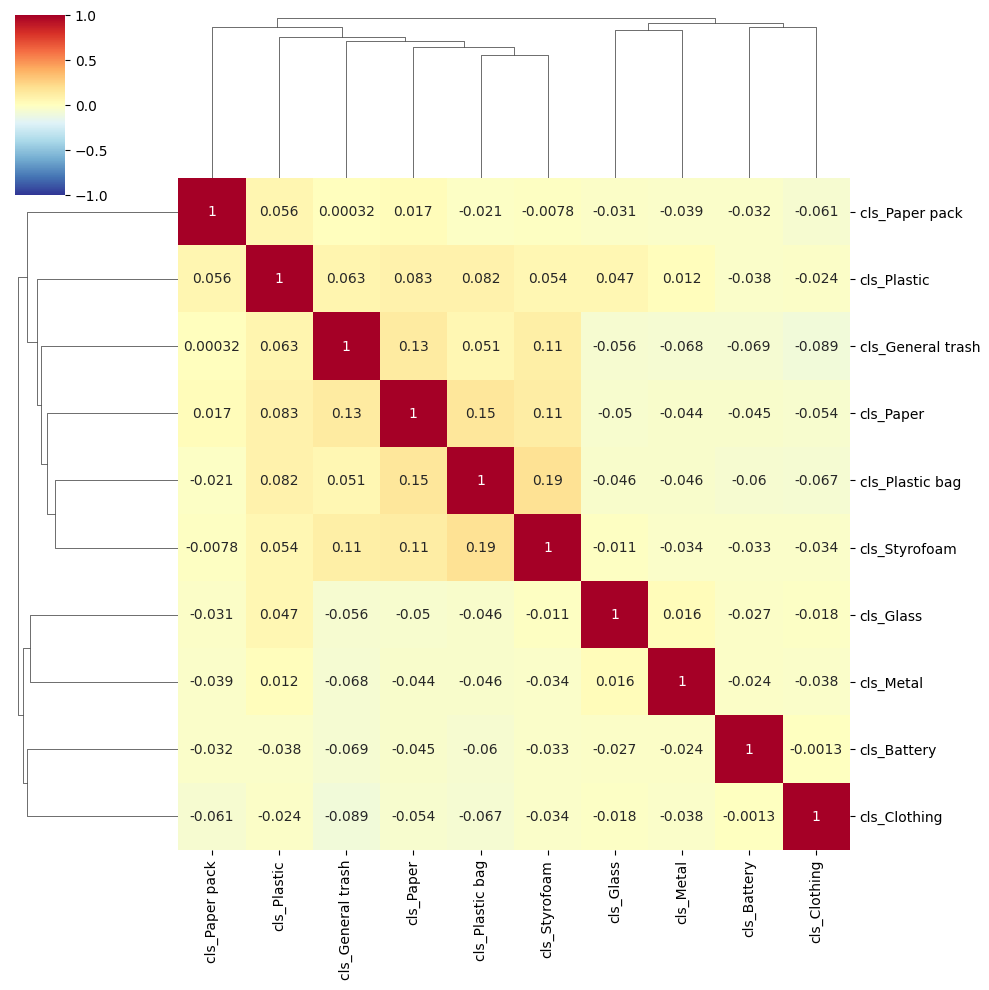

In [33]:
from easydict import EasyDict
cfg = EasyDict(
    anno_path = '../../dataset/train.json',
    classes = ["Unknown", "General trash", "Paper", "Paper pack", "Metal", "Glass", 
            "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"],
    hist_width = 1000,
    hist_height = 400
)

train_df = load(cfg)

# hist_ann_per_img(train_df, cfg)
# hist_cls_per_img(train_df, cfg)
# hist_ann_per_cls(train_df, cfg)

bbox_df = convert_to_bbox(train_df)

# heat_bbox(bbox_df, cfg)
# box_bbox_area(bbox_df, cfg)
# box_aspect_ratio(bbox_df, cfg)

corr_df = convert_to_corr(train_df)
corr_df

heat_corr_cls_per_img(corr_df)

# get_statisitcs(train_df, bbox_df)

In [7]:
train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max
0,train/0000.jpg,General trash,1,198.0,194.0,745.0,663.0
1,train/0001.jpg,Plastic bag,8,0.0,456.0,145.0,637.0
2,train/0001.jpg,Glass,5,722.0,313.0,997.0,565.0
3,train/0001.jpg,Plastic,6,353.0,671.0,587.0,774.0
4,train/0001.jpg,Plastic,6,4.0,448.0,782.0,690.0
...,...,...,...,...,...,...,...
23407,train/4881.jpg,Plastic bag,8,151.0,485.0,692.0,859.0
23408,train/4882.jpg,Plastic,6,0.0,116.0,944.0,930.0
23409,train/4882.jpg,General trash,1,511.0,451.0,570.0,481.0
23410,train/4882.jpg,Paper,2,255.0,421.0,527.0,616.0


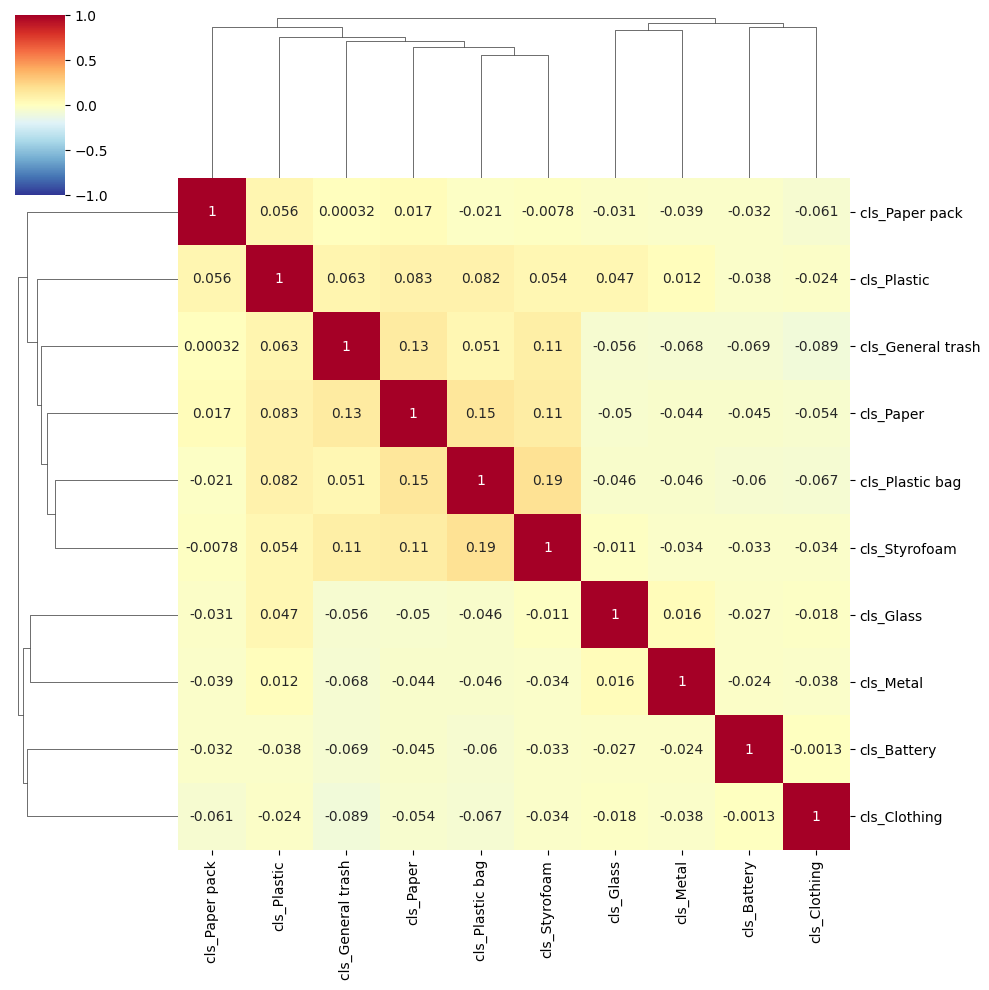

In [24]:

# train_df

In [ ]:
bbox_df.groupby('class_id')
# train_df

,image_id,class_name,class_id,x_min,y_min,x_max,y_max
0,train/0000.jpg,General trash,1,198.0,194.0,745.0,663.0
1,train/0001.jpg,Plastic bag,8,0.0,456.0,145.0,637.0
2,train/0001.jpg,Glass,5,722.0,313.0,997.0,565.0
3,train/0001.jpg,Plastic,6,353.0,671.0,587.0,774.0
4,train/0001.jpg,Plastic,6,4.0,448.0,782.0,690.0
...,...,...,...,...,...,...,...
23407,train/4881.jpg,Plastic bag,8,151.0,485.0,692.0,859.0
23408,train/4882.jpg,Plastic,6,0.0,116.0,944.0,930.0
23409,train/4882.jpg,General trash,1,511.0,451.0,570.0,481.0
23410,train/4882.jpg,Paper,2,255.0,421.0,527.0,616.0
